In [280]:
from kiutils.board import Board
import numpy as np
import cv2 as cv
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline




board = Board.from_file('polygon_paste_2.kicad_pcb')

In [281]:
board.zones[0].filledPolygons[0]

FilledPolygon(layer='F.Cu', island=False, coordinates=[Position(X=-6.576695, Y=-137.413227, angle=None, unlocked=False), Position(X=-6.550588, Y=-137.393276, angle=None, unlocked=False), Position(X=-5.642938, Y=-136.485626, angle=None, unlocked=False), Position(X=-5.642928, Y=-136.485615, angle=None, unlocked=False), Position(X=-5.638598, Y=-136.481285, angle=None, unlocked=False), Position(X=-5.638597, Y=-136.481284, angle=None, unlocked=False), Position(X=-5.526793, Y=-136.36948, angle=None, unlocked=False), Position(X=-5.454786, Y=-136.327908, angle=None, unlocked=False), Position(X=-5.439982, Y=-136.319361, angle=None, unlocked=False), Position(X=-5.43998, Y=-136.319359, angle=None, unlocked=False), Position(X=-5.401633, Y=-136.297219, angle=None, unlocked=False), Position(X=-5.389862, Y=-136.290423, angle=None, unlocked=False), Position(X=-5.237135, Y=-136.2495, angle=None, unlocked=False), Position(X=-5.237134, Y=-136.2495, angle=None, unlocked=False), Position(X=-4.264141, Y=-13

In [282]:
polygon_vertices = np.array([[coordinate.X, -coordinate.Y] for coordinate in board.zones[0].filledPolygons[0].coordinates])
polygon = Polygon(polygon_vertices)

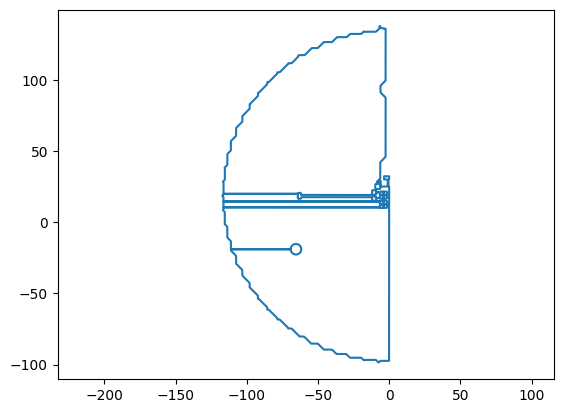

In [283]:
x,y = polygon.exterior.xy
plt.axis('equal')
plt.plot(x,y)
plt.show()

In [284]:
padding = 10

min_x = np.min(polygon_vertices[:,0])-padding
max_x = np.max(polygon_vertices[:,0])+padding
min_y = np.min(polygon_vertices[:,1])-padding
max_y = np.max(polygon_vertices[:,1])+padding

# create grid
grid_resolution = 2 # mm
grid = np.zeros((int((max_y - min_y)/grid_resolution), int((max_x - min_x)/grid_resolution)), dtype=np.uint8)

In [285]:
# rasterize polygon
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        cell_top_left = [min_x + j*grid_resolution, min_y + i*grid_resolution]
        # take 4 samples 
        for k in range(2):
            for l in range(2):
                point = [cell_top_left[0] + k*grid_resolution/2 + grid_resolution/4, cell_top_left[1] + l*grid_resolution/2 + grid_resolution/4]
        
                if polygon.contains(Point(point)):
                    grid[i,j] += 1

# threshold
grid = (grid > 1).astype(np.uint8)

# erode once
kernel = np.ones((3,3))
grid = cv.erode(grid, kernel, iterations=1)

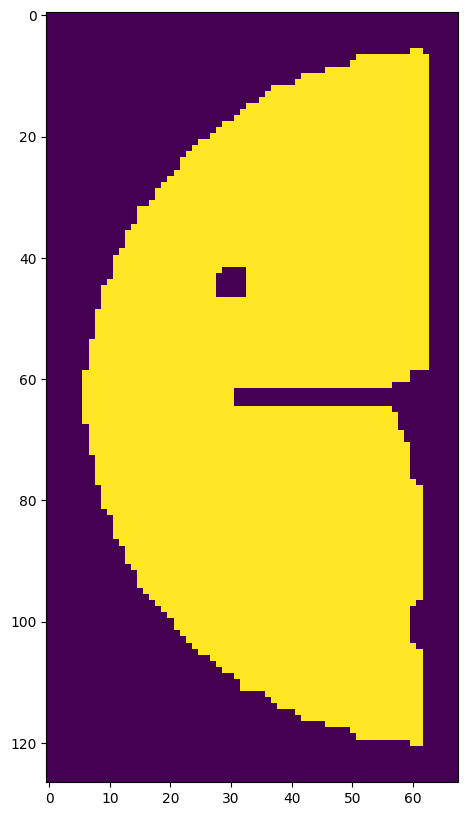

In [286]:
# plot
fig = plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.show()

In [287]:
final_erosion_point = [0., 0.]

grid_copy = grid.copy()
while np.sum(grid_copy) > 0:
    final_erosion_point = np.array(np.where(grid_copy == 1)).mean(axis=1)
    grid_copy = cv.erode(grid_copy, kernel, iterations=1)

final_erosion_point

array([84.26666667, 39.4       ])

In [288]:
def polygon_is_clockwise(points):
    sum = 0
    for i in range(len(points)):
        sum += (points[i][0] - points[(i+1)%len(points)][0]) * (points[i][1] + points[(i+1)%len(points)][1])
    return sum < 0

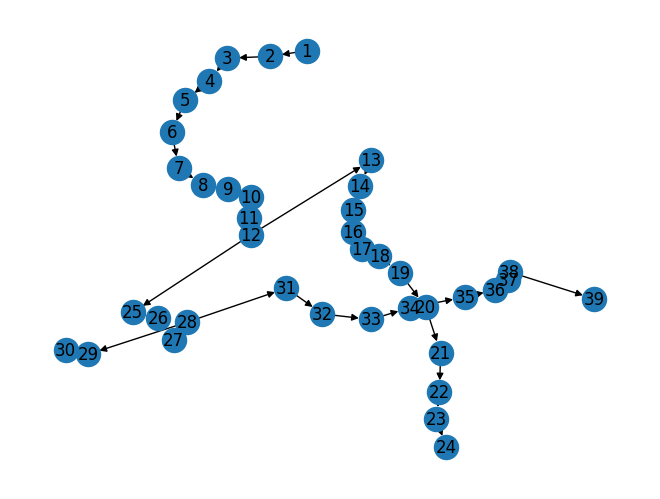

In [289]:
contour_tree = nx.DiGraph()


grid_copy = grid.copy()

node_id = 0
def get_contour_tree(grid, parent_id=None, level=0):
    global node_id

    # remove lines of one pixel
    horizontal_kernel = np.array([[-1, -1, -1],
                                  [ 0,  1,  0],
                                  [-1, -1, -1]])
    vertical_kernel = np.array([[-1,  0, -1],
                                [-1,  1, -1],
                                [-1,  0, -1]])
    up_diagonal_kernel = np.array([[ 0, -1, -1],
                                   [-1,  1, -1],
                                   [-1, -1,  0]])
    down_diagonal_kernel = np.array([[-1, -1,  0],
                                     [-1,  1, -1],
                                     [ 0, -1, -1]])
    
    for i in range(10):
        horizontal_mask = cv.filter2D(grid, -1, horizontal_kernel) == 1
        vertical_mask = cv.filter2D(grid, -1, vertical_kernel) == 1
        up_diagonal_mask = cv.filter2D(grid, -1, up_diagonal_kernel) == 1
        down_diagonal_mask = cv.filter2D(grid, -1, down_diagonal_kernel) == 1

        mask = np.bitwise_or(np.bitwise_or(horizontal_mask, vertical_mask), np.bitwise_or(up_diagonal_mask, down_diagonal_mask))
        grid = np.bitwise_and(grid, ~mask)

    contours, _ = cv.findContours(grid.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    for contour_line in contours:
        contour_line = contour_line.reshape(-1, 2)

        # skip if contour has no area
        if cv.contourArea(contour_line) == 0:
            continue

        # close contour loop
        # contour_line = np.vstack([contour_line, contour_line[0]])

        # make sure contour is anti-clockwise
        if polygon_is_clockwise(contour_line):
            contour_line = contour_line[::-1]

        # build tree
        node_id += 1
        contour_tree.add_node(node_id, line=contour_line, level=level)
        if parent_id is not None:
            contour_tree.add_edge(parent_id, node_id)

        # isolate contour and erode boundary
        grid_mask = np.zeros_like(grid)
        grid_mask = cv.drawContours(grid_mask, [contour_line], -1, 1, -1)
        for cell in contour_line:
            grid_mask[cell[1], cell[0]] = 0
        new_grid = np.bitwise_and(grid, grid_mask)

        # recurse
        get_contour_tree(new_grid, parent_id=node_id, level=level+1)
        
get_contour_tree(grid_copy)

# print tree
pos = nx.spring_layout(contour_tree)
nx.draw(contour_tree, pos, with_labels=True)


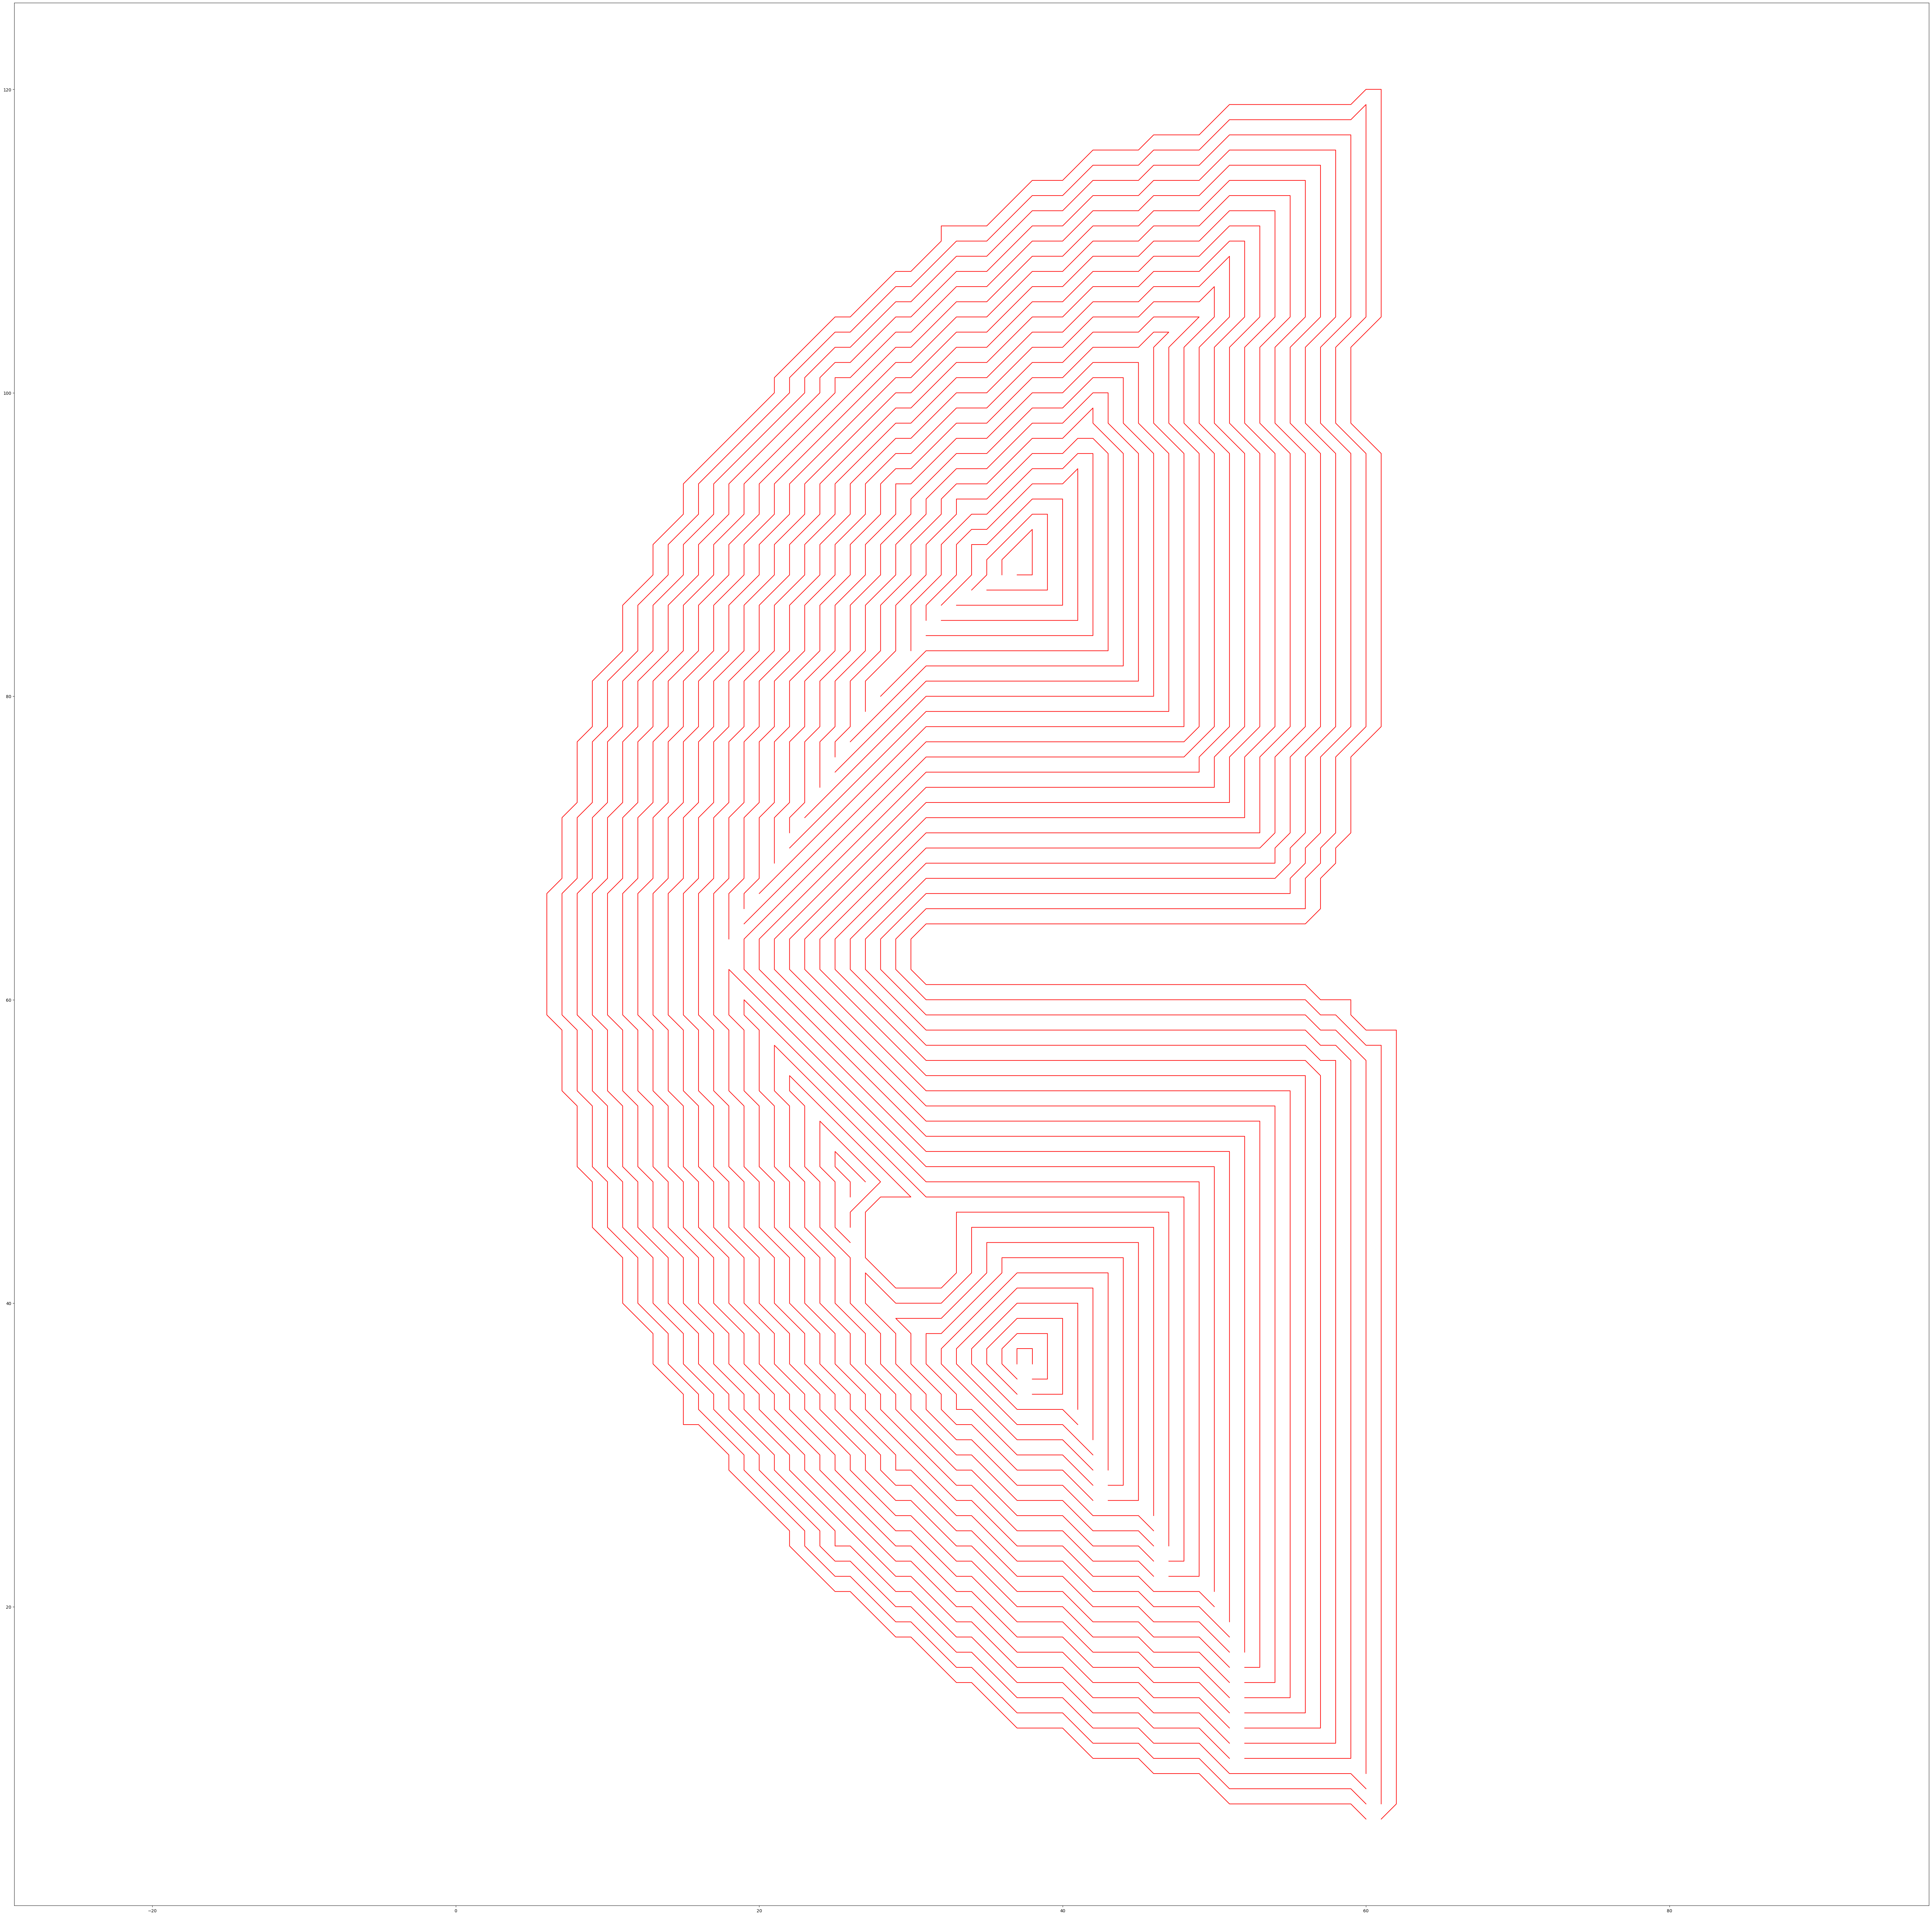

In [290]:
# plot contours
for node_id in list(contour_tree.nodes):
    contour_data = contour_tree.nodes[node_id]
    contour_line = contour_data["line"]
    # plt.quiver(contour_line[:-1,0], contour_line[:-1,1], contour_line[1:,0]-contour_line[:-1,0], contour_line[1:,1]-contour_line[:-1,1], scale_units='xy', angles='xy', scale=1, color='r')
    plt.plot(contour_line[:,0], contour_line[:,1], color='r')

fig = plt.gcf()
fig.set_size_inches(80, 80)
plt.axis('equal')
plt.show()

In [291]:
# get leaf nodes
leaf_nodes = [node_id for node_id in contour_tree.nodes() if contour_tree.out_degree(node_id) == 0]
leaf_nodes

[24, 30, 39]

In [292]:
contour_tree_copy = contour_tree.copy()

(3.1999999999999997, 64.8, 0.2999999999999998, 125.7)

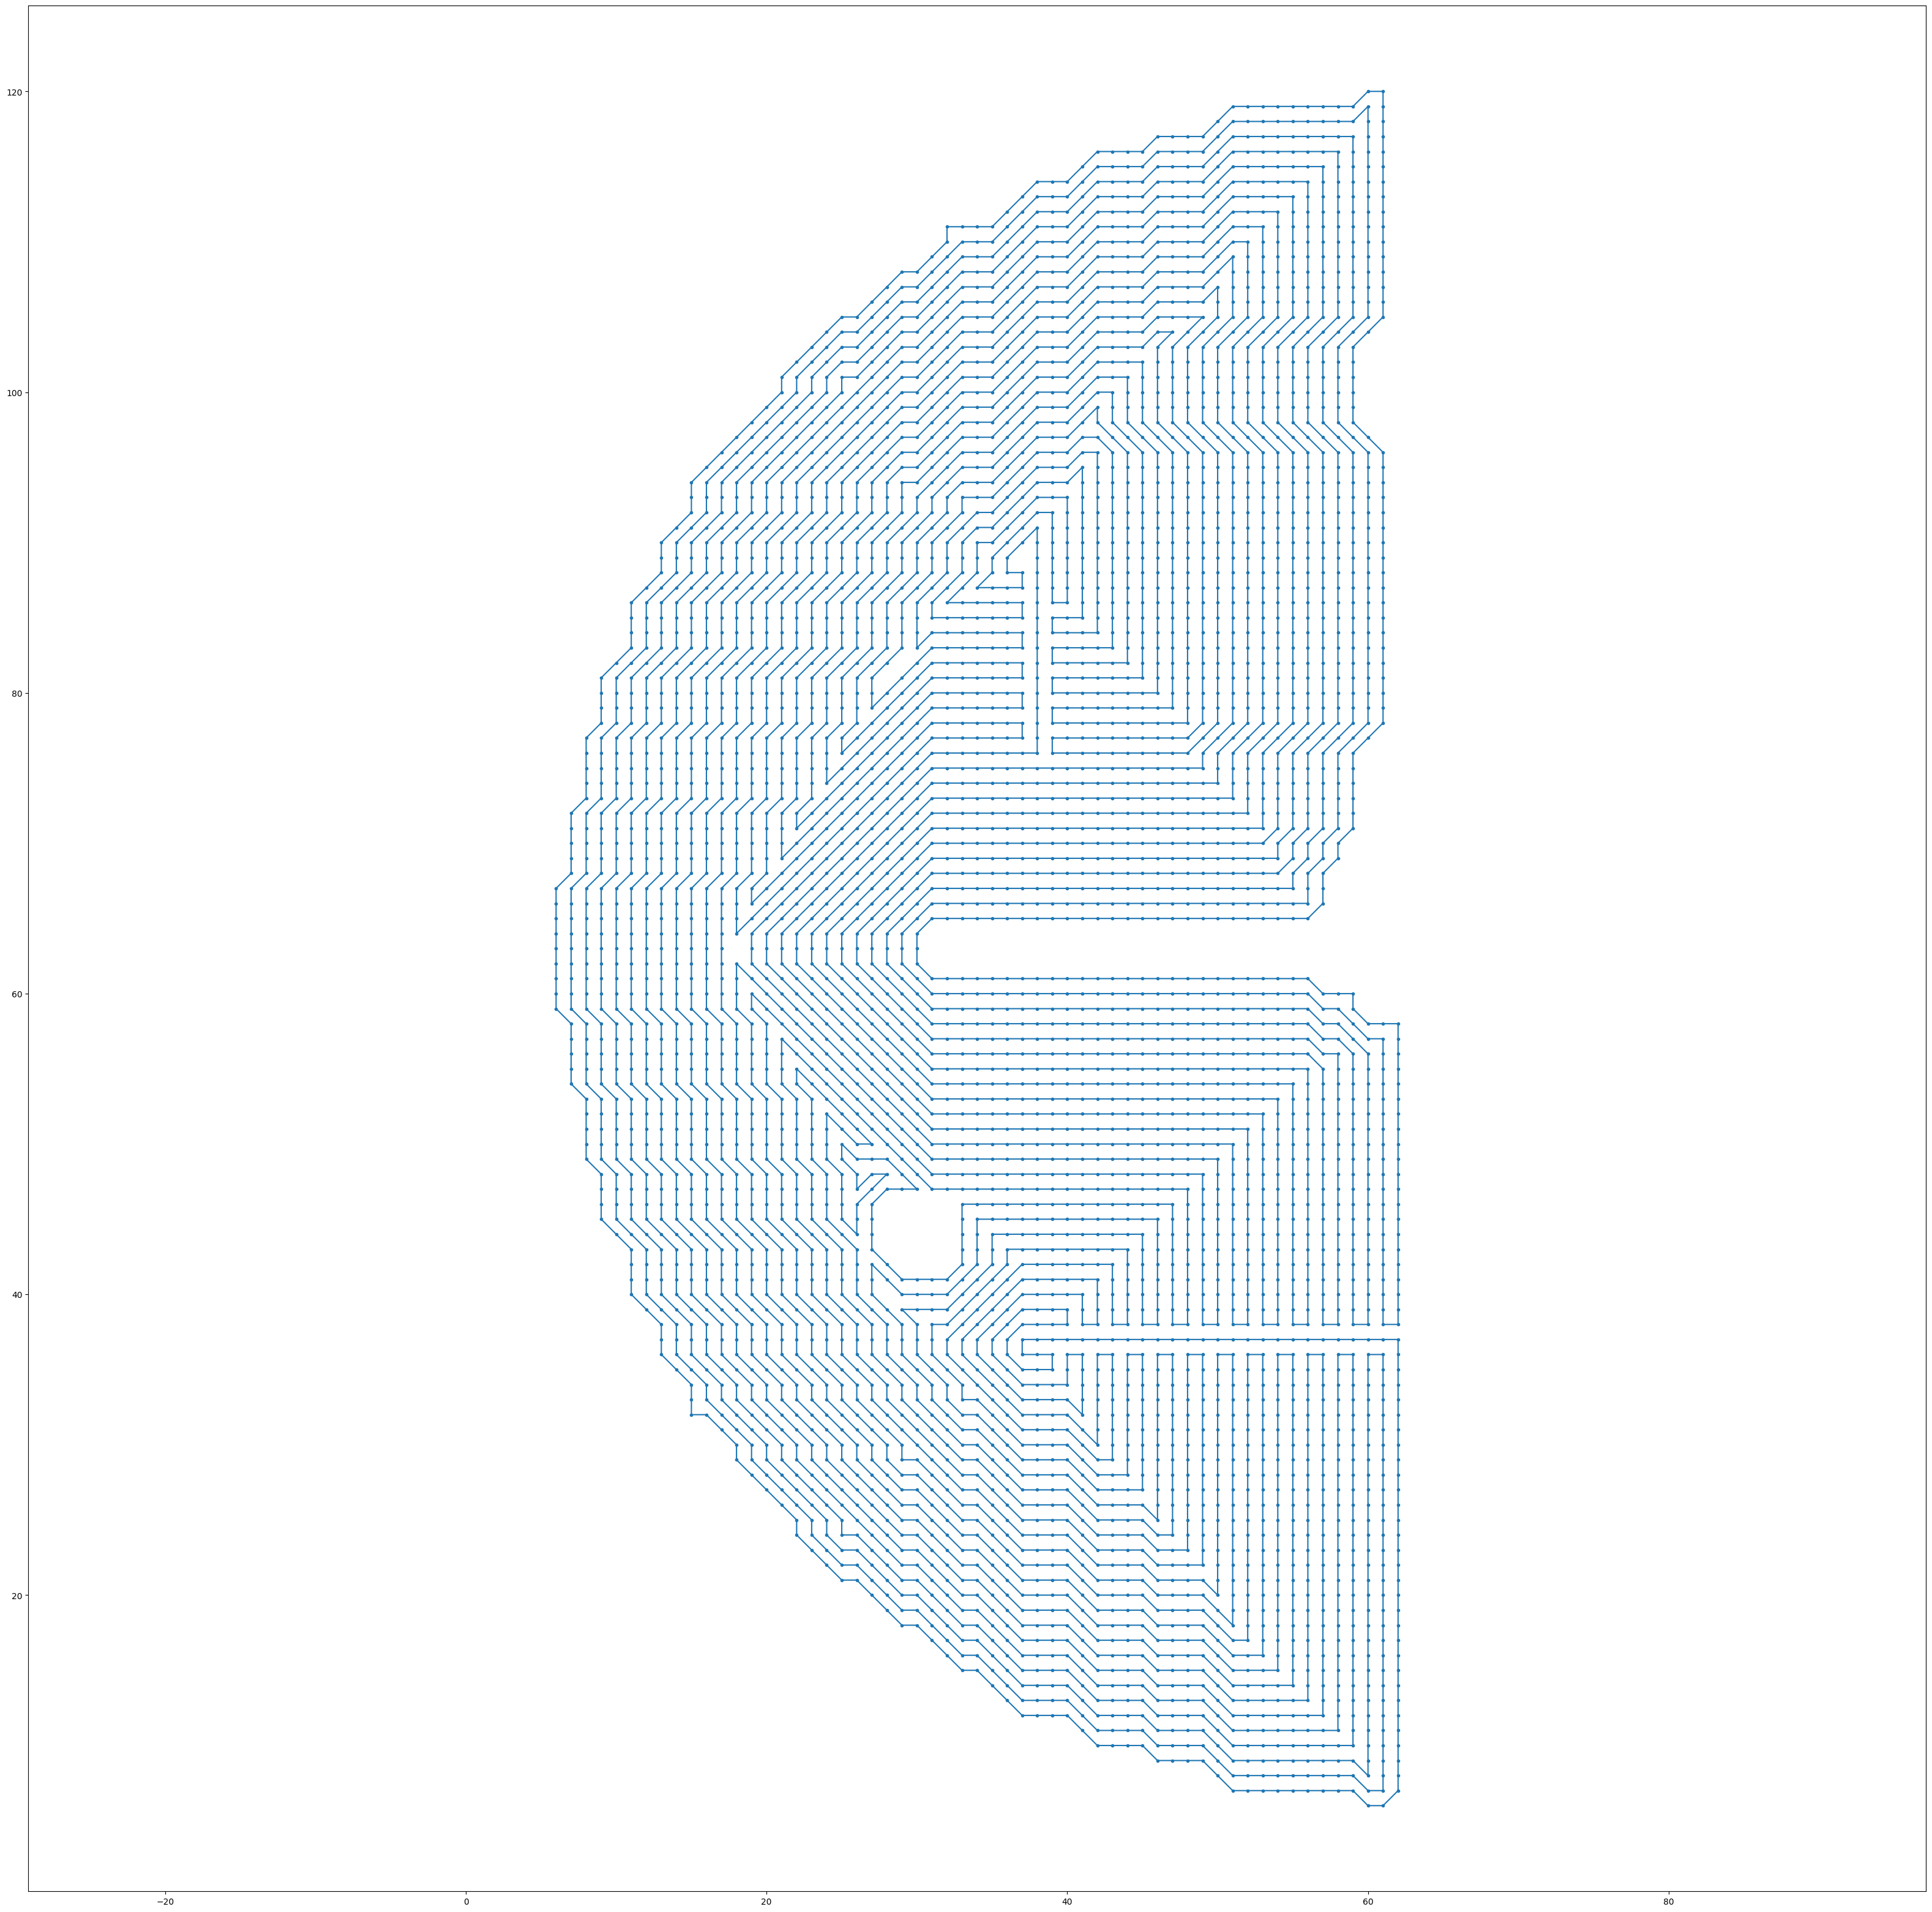

In [293]:
contour_tree = contour_tree_copy.copy()

new_line = np.empty((0,2))
prev_connection_points = np.empty((0,3,2))

# mark and sweep from leaf nodes upwards
def mark_and_sweep(contour_tree, node_id, marked_nodes, new_line, prev_connection_points, alternating=False):
    if node_id in marked_nodes:
        return
    
    contour_data = contour_tree.nodes[node_id]
    contour_line = contour_data["line"]

    # get connection point
    if prev_connection_points.size > 0:
        last_connection_points = prev_connection_points[-1]
        
        # get point on contour line closest to previous connection point
        delta = contour_line - last_connection_points[1]
        distances = np.linalg.norm(delta, axis=1)
        connection_point_index = np.argmin(distances)
    else:
        connection_point_index = 1
    connection_point_index_left = connection_point_index - 1 if connection_point_index > 0 else -1
    connection_point_index_right = connection_point_index + 1 if connection_point_index < len(contour_line) - 1 else 0

    current_connection_points = contour_line[[connection_point_index_left, connection_point_index, connection_point_index_right]]

    # connect adjacent connection point to previous adjacent connection point (alternating)
    if prev_connection_points.size > 0:
        last_connection_points = prev_connection_points[-1]

        if alternating:
            new_line = np.append(new_line, [last_connection_points[0], current_connection_points[0]], axis=0)
        else:
            new_line = np.append(new_line, [last_connection_points[2], current_connection_points[2]], axis=0)

    # add contour line to new line excluding connection point
    contour_line_excluding_connection_points = np.delete(contour_line, [connection_point_index_left, connection_point_index, connection_point_index_right], axis=0)
    contour_line_excluding_connection_points = np.roll(contour_line_excluding_connection_points, -connection_point_index_right+2, axis=0) # roll around to start at connection point + 1
    if alternating:
        contour_line_excluding_connection_points = np.flip(contour_line_excluding_connection_points, axis=0)
    new_line = np.append(new_line, contour_line_excluding_connection_points, axis=0)

    prev_connection_points = np.append(prev_connection_points, [current_connection_points], axis=0)
    
    all_children_finished = np.all(np.in1d(list(contour_tree.successors(node_id)), list(marked_nodes))) # force computation of children first if not already done
    is_root_node = contour_tree.in_degree(node_id) == 0
    if not all_children_finished or is_root_node:
        # add exit line
        index = 2 if alternating else 0
        new_line = np.append(new_line, [prev_connection_points[-1][index]], axis=0)
        for connection_points in np.flip(prev_connection_points, axis=0):
            new_line = np.append(new_line, [connection_points[1]], axis=0)
        new_line = np.append(new_line, [prev_connection_points[0][2]], axis=0)

        # this is now a new continuious "contour" line, so collapse tree branch containing finished child into one node
        for child in contour_tree.successors(node_id):
            if child in marked_nodes:
                contour_tree.remove_node(child)
                break
        # make sure new line is anti-clockwise
        if polygon_is_clockwise(new_line):
            new_line = np.flip(new_line, axis=0)
            
        nx.set_node_attributes(contour_tree, {node_id: {"line": new_line}})

        return new_line
    
    marked_nodes.add(node_id)

    for predecessor in list(contour_tree.predecessors(node_id)):
        new_line = mark_and_sweep(contour_tree, predecessor, marked_nodes, new_line, prev_connection_points, not alternating)

    return new_line

marked_nodes = set()
for leaf_node in leaf_nodes:
    trace = mark_and_sweep(contour_tree, leaf_node, marked_nodes, new_line, prev_connection_points)

# new_line_a = mark_and_sweep(contour_tree, leaf_nodes[0], marked_nodes, new_line, prev_connection_points)
# new_line_a = mark_and_sweep(contour_tree, leaf_nodes[1], marked_nodes, new_line, prev_connection_points)
# new_line_a = mark_and_sweep(contour_tree, leaf_nodes[2], marked_nodes, new_line, prev_connection_points)

# close loop
trace = np.vstack([trace, trace[0]])

# plot new line with direction
fig = plt.gcf()
fig.set_size_inches(40, 40)
# plt.quiver(trace[:-1,0], trace[:-1,1], trace[1:,0]-trace[:-1,0], trace[1:,1]-trace[:-1,1], scale_units='xy', angles='xy', scale=1, linewidth=0)
plt.plot(trace[:,0], trace[:,1], marker=".")
plt.axis('equal')

In [294]:
# verify path is closed and does not intersect itself
trace = np.vstack([trace, trace[0]])
new_polygon = Polygon(trace)
assert new_polygon.is_valid
assert new_polygon.is_simple

In [295]:
trace_length = np.sum(np.linalg.norm(trace[1:] - trace[:-1], axis=1)) * grid_resolution
wattage = 0.0045*polygon.area # same power density as MK2b heated bed
resistance = 24**2 / wattage
temp = 60
trace_height = 0.035 # mm
p_copper = 1.7e-5 # ohm-mm
a_copper = 3.9e-3 # ohm/ohm/C
trace_width = (p_copper * trace_length * (1 + a_copper * (temp - 25))) / (resistance * trace_height)

print(f"trace length:               {trace_length:.1f} mm")
print(f"area:                       {polygon.area:.1f} mm^2")
print(f"suggested wattage:          {wattage:.1f} W")
print(f"suggested resistance @ 24v: {resistance:.1f} Ohm")
print(f"suggested trace width:      {trace_width:.2f} mm")

trace length:               10684.7 mm
area:                       20698.2 mm^2
suggested wattage:          93.1 W
suggested resistance @ 24v: 6.2 Ohm
suggested trace width:      0.95 mm


In [296]:
from kiutils.items.brditems import Segment, LayerToken
from kiutils.items.common import Net, Position
import uuid

# create netlist of path
new_board = Board(
    version="20240108", 
    generator="KiUtils", 
    layers=[
        LayerToken(ordinal=0, name="F.Cu"),
        LayerToken(ordinal=1, name="B.Cu"),
    ], 
    nets=[Net(number=0, name="")]
)

for i in range(len(trace)-1):
    new_board.traceItems.append(Segment(start=Position(X=trace[i][0] * grid_resolution, Y=-trace[i][1] * grid_resolution), end=Position(X=trace[i+1][0] * grid_resolution, Y=-trace[i+1][1] * grid_resolution), net="0", layer="F.Cu", width=trace_width, tstamp=uuid.uuid4()))

new_board.to_file("trace.kicad_pcb")